In [128]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
data=pd.read_excel(r'D:\data_storage\Projects\flight_price_ml\data.xlsx')
data.head(5)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [131]:
#---------------------------
#Cleaning
#---------------------------

In [132]:
data['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [133]:
#Additional_Info doesn't provide much information, let's drop it
data.drop(columns=['Additional_Info'],inplace=True);

In [134]:
sum=data.isnull().sum()
pd.DataFrame({'count':sum,'%':sum*100/data.shape[0]})

,count,%
Airline,0,0.000000
Date_of_Journey,0,0.000000
Source,0,0.000000
Destination,0,0.000000
Route,1,0.009361
Dep_Time,0,0.000000
Arrival_Time,0,0.000000
Duration,0,0.000000
Total_Stops,1,0.009361
Price,0,0.000000


In [135]:
#clearing rows with nulls
data.dropna(inplace=True)

In [136]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Price               int64
dtype: object

In [137]:
#---------------------------
#Early Encoding
#---------------------------

In [138]:
#source-destination
data['Source-Destination']=data[['Source','Destination']].apply('-'.join,axis=1)
source_destination=pd.get_dummies(data['Source-Destination'])
source_destination=source_destination.rename({k:'Route_'+k for k in source_destination.columns},axis=1)
data=data.join(source_destination)

data.head(1)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Source-Destination,Route_Banglore-Delhi,Route_Banglore-New Delhi,Route_Chennai-Kolkata,Route_Delhi-Cochin,Route_Kolkata-Banglore,Route_Mumbai-Hyderabad
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,3897,Banglore-New Delhi,0,1,0,0,0,0


In [139]:
#airline
airline=pd.get_dummies(data['Airline'])
airline=airline.rename({k:'Airline_'+k for k in airline.columns},axis=1)
data=data.join(airline)

data.head(1)


,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,3897,...,0,1,0,0,0,0,0,0,0,0


In [140]:
#Converting to datetime
for col in ['Date_of_Journey','Dep_Time','Arrival_Time']:
  data[col]=pd.to_datetime(data[col],dayfirst=True)

#converting time to decimal hours
for col in ['Dep_Time',"Arrival_Time"]:
  data[col+'_Hour']=data[col].dt.hour+data[col].dt.minute/60

#converting date to decimal month to capture seasonal patterns
doj=data['Date_of_Journey']
data['Date_of_Journey_Month']=doj.dt.month+(doj.dt.day/doj.dt.days_in_month)

#Day of week to capture weekly pattern
data['Date_of_Journey_Day_of_Week']=data['Date_of_Journey'].dt.day_of_week
dow=data.groupby(data['Date_of_Journey_Day_of_Week'])['Price'].mean()
data['Date_of_Week_Mean']=data['Date_of_Journey_Day_of_Week'].map(dow)

data.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Dep_Time_Hour,Arrival_Time_Hour,Date_of_Journey_Month,Date_of_Journey_Day_of_Week,Date_of_Week_Mean
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2023-02-21 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,3897,...,0,0,0,0,0,22.333333,1.166667,3.774194,6,9525.50882
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,2023-02-21 05:50:00,2023-02-21 13:15:00,7h 25m,2 stops,7662,...,0,0,0,0,0,5.833333,13.250000,5.032258,2,9277.51419
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,2023-02-21 09:25:00,2023-06-10 04:25:00,19h,2 stops,13882,...,0,0,0,0,0,9.416667,4.416667,6.300000,6,9525.50882


In [141]:
#parsing duration
def preprocess_duration(x):
  if 'h' not in x:
      x='0h '+x
  elif 'm' not in x:
      x=x+' 0m'
  return x

data['Duration']=data['Duration'].apply(preprocess_duration)

def str_time_parser(x):
  a=x.split(' ')
  return(int(a[0][0:-1])+int(a[1][0:-1])/60)

data['Duration_Hour']=data['Duration'].apply(lambda x: str_time_parser(x))

data[['Duration','Duration_Hour']].head(3)



,Duration,Duration_Hour
0,2h 50m,2.833333
1,7h 25m,7.416667
2,19h 0m,19.000000


In [142]:
#counting number of stops
data['Stops_Count']=data['Route'].apply(lambda x: x.count('→')-1)
data[['Route','Stops_Count']].head(6)


,Route,Stops_Count
0,BLR → DEL,0
1,CCU → IXR → BBI → BLR,2
2,DEL → LKO → BOM → COK,2
3,CCU → NAG → BLR,1
4,BLR → NAG → DEL,1
5,CCU → BLR,0


In [143]:
data['Stops_Count'].value_counts()

1    5625
0    3491
2    1520
3      45
4       1
Name: Stops_Count, dtype: int64

In [144]:
#---------------------------
#Exploration
#---------------------------
data.head(1)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,...,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Dep_Time_Hour,Arrival_Time_Hour,Date_of_Journey_Month,Date_of_Journey_Day_of_Week,Date_of_Week_Mean,Duration_Hour,Stops_Count
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,2023-02-21 22:20:00,2023-03-22 01:10:00,2h 50m,non-stop,3897,...,0,0,0,22.333333,1.166667,3.774194,6,9525.50882,2.833333,0


<Axes: xlabel='Airline', ylabel='Price'>

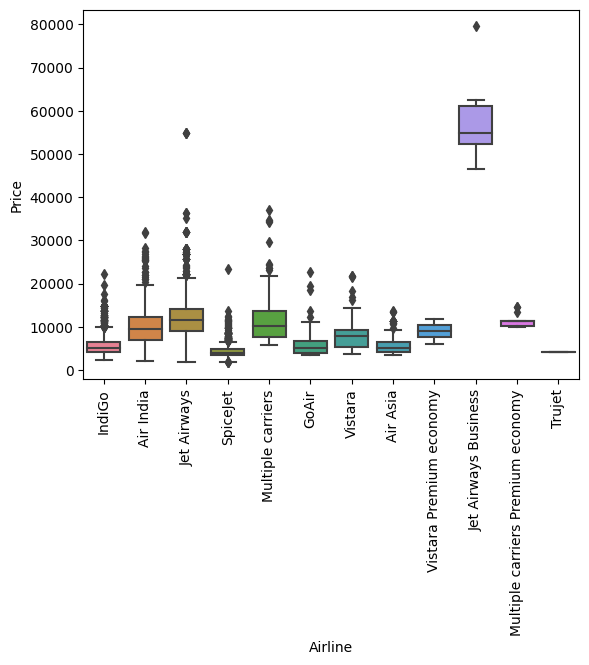

In [145]:
#A look at the effect of airline on price
plot=sns.boxplot(data=data,x='Airline',y='Price',palette="husl")
plt.setp(plot.get_xticklabels(),rotation=90)
plot


<Axes: xlabel='Source-Destination', ylabel='Price'>

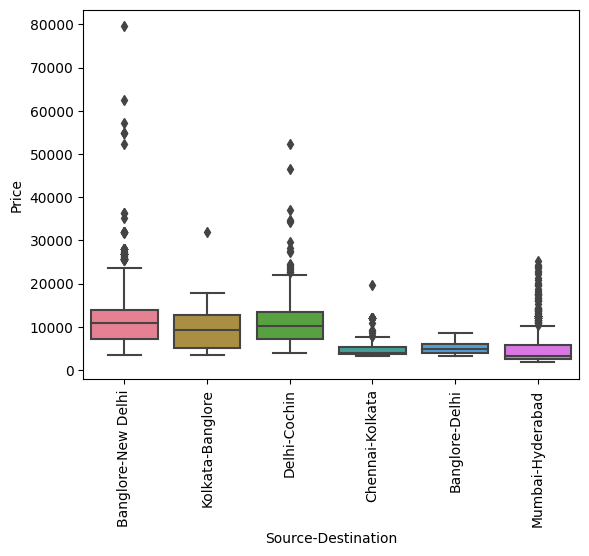

In [146]:
#A look at the effect of the route on price
plot=sns.boxplot(data=data,x='Source-Destination',y='Price',palette="husl")
plt.setp(plot.get_xticklabels(),rotation=90)
plot

<Axes: xlabel='Stops_Count', ylabel='Price'>

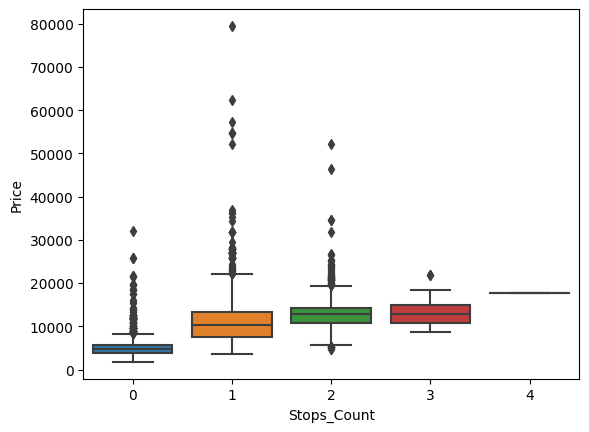

In [147]:
#Look a the effect of the number of stops on price
plot=sns.boxplot(data=data,x='Stops_Count',y='Price')
plot

<Axes: xlabel='Source-Destination', ylabel='Price'>

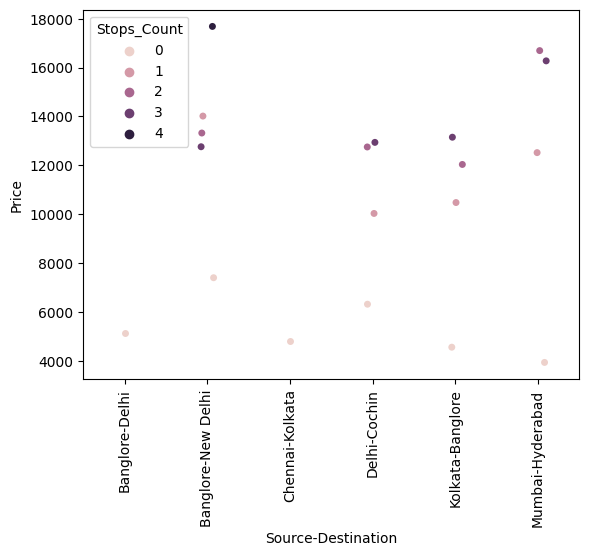

In [148]:
#Perhaps the reason the price increases with the number of stops
#is becaused it is a longer route...Let's see
group=data[['Source-Destination','Stops_Count','Price']].groupby(['Source-Destination','Stops_Count']).mean()
plot=sns.stripplot(data=group,x='Source-Destination',y='Price',hue='Stops_Count')
plt.setp(plot.get_xticklabels(),rotation=90)
plot

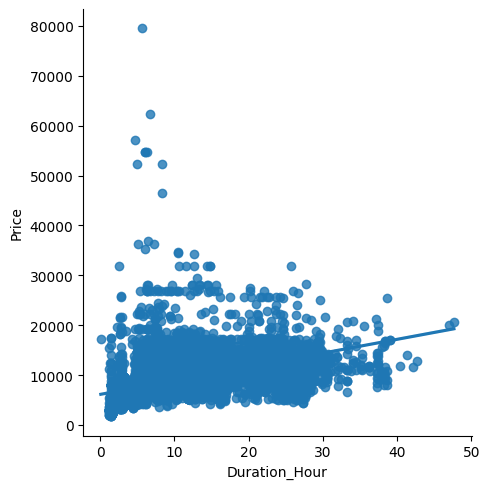

In [149]:
#It seems more stops simply = more expensive
#Let's look at the impact of flight duration
plot=sns.lmplot(data=data,x='Duration_Hour',y='Price')
plot

In [150]:
#It is probably highly collinear with number of stops
data['Stops_Count'].corr(data['Duration_Hour'])

0.7380709166001782

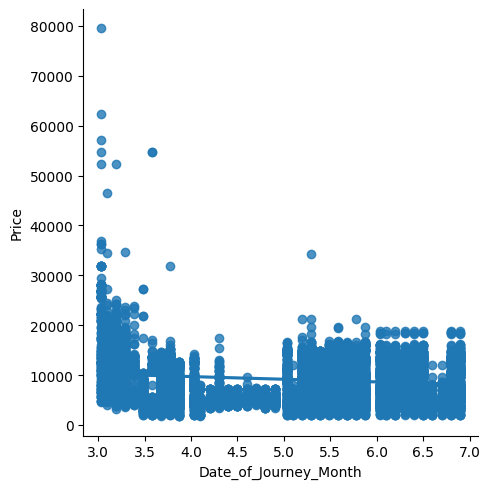

In [151]:
#Let's look at the effect of the month
sns.lmplot(data=data,x='Date_of_Journey_Month',y='Price')


<Axes: xlabel='Date_of_Journey_Month', ylabel='Price'>

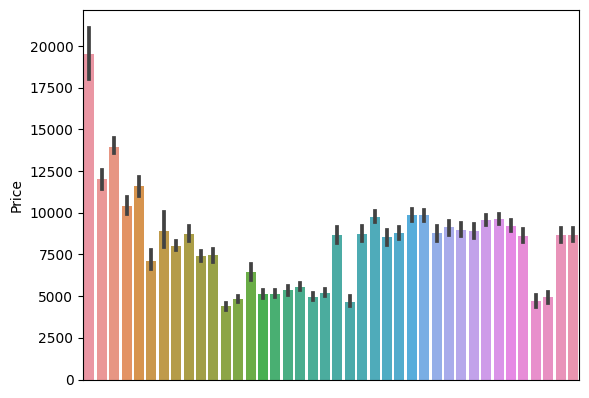

In [152]:
#It looks like the month has a non-linear relationship with price
plot=sns.barplot(data=data,x='Date_of_Journey_Month',y='Price')
plot.axes.get_xaxis().set_visible(False)
plot

In [153]:
#Let's discretize and take the mean of each bin
#Data only spans 4 month so lets make 52/3 bins to have one bin per week
bins=pd.cut(data['Date_of_Journey_Month'],bins=17)
bins

0        (3.715, 3.942]
1         (4.852, 5.08]
2        (6.217, 6.445]
3        (5.307, 5.535]
4         (3.028, 3.26]
              ...      
10678     (4.17, 4.397]
10679     (4.852, 5.08]
10680     (4.852, 5.08]
10681     (3.028, 3.26]
10682     (5.08, 5.307]
Name: Date_of_Journey_Month, Length: 10682, dtype: category
Categories (17, interval[float64, right]): [(3.028, 3.26] < (3.26, 3.487] < (3.487, 3.715] < (3.715, 3.942] ... (5.99, 6.217] < (6.217, 6.445] < (6.445, 6.672] < (6.672, 6.9]]

In [154]:
data['Date_Bin']=bins
data[['Date_of_Journey_Month','Date_Bin']].head(10)

,Date_of_Journey_Month,Date_Bin
0,3.774194,"(3.715, 3.942]"
1,5.032258,"(4.852, 5.08]"
2,6.300000,"(6.217, 6.445]"
3,5.387097,"(5.307, 5.535]"
4,3.032258,"(3.028, 3.26]"
5,6.800000,"(6.672, 6.9]"
6,3.387097,"(3.26, 3.487]"
7,3.032258,"(3.028, 3.26]"
8,3.387097,"(3.26, 3.487]"
9,5.870968,"(5.762, 5.99]"


In [155]:
#Looks alrigth
#Let's get the mean of each bin
date_bins=data.groupby(['Date_Bin'])['Price'].mean()
date_bins

Date_Bin
(3.028, 3.26]     14511.296619
(3.26, 3.487]      9806.696370
(3.487, 3.715]     8258.065630
(3.715, 3.942]     8107.194534
(3.942, 4.17]      6533.068120
(4.17, 4.397]      5726.262222
(4.397, 4.625]     5192.456621
(4.625, 4.852]     5251.793103
(4.852, 5.08]      7809.819407
(5.08, 5.307]      8886.160234
(5.307, 5.535]     8674.423193
(5.535, 5.762]     9853.281718
(5.762, 5.99]      8980.893713
(5.99, 6.217]      9217.500000
(6.217, 6.445]     9411.203441
(6.445, 6.672]     7683.581986
(6.672, 6.9]       8169.368098
Name: Price, dtype: float64

In [156]:
#Finally let's add it to the frame
data['Date_Bin_Mean']=data['Date_Bin'].map(date_bins).astype(float)
data[['Date_of_Journey_Month','Date_Bin','Date_Bin_Mean']].head(10)

,Date_of_Journey_Month,Date_Bin,Date_Bin_Mean
0,3.774194,"(3.715, 3.942]",8107.194534
1,5.032258,"(4.852, 5.08]",7809.819407
2,6.300000,"(6.217, 6.445]",9411.203441
3,5.387097,"(5.307, 5.535]",8674.423193
4,3.032258,"(3.028, 3.26]",14511.296619
5,6.800000,"(6.672, 6.9]",8169.368098
6,3.387097,"(3.26, 3.487]",9806.696370
7,3.032258,"(3.028, 3.26]",14511.296619
8,3.387097,"(3.26, 3.487]",9806.696370
9,5.870968,"(5.762, 5.99]",8980.893713


<Axes: xlabel='Date_Bin', ylabel='Date_Bin_Mean'>

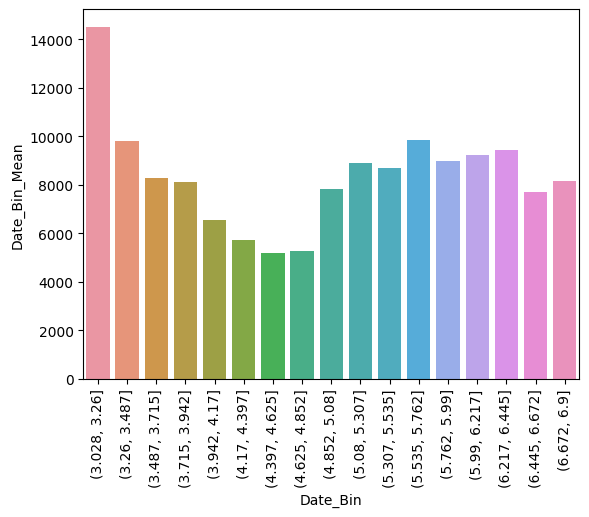

In [157]:
plot=sns.barplot(data=data,x='Date_Bin',y='Date_Bin_Mean')
plt.setp(plot.get_xticklabels(),rotation=90)
plot

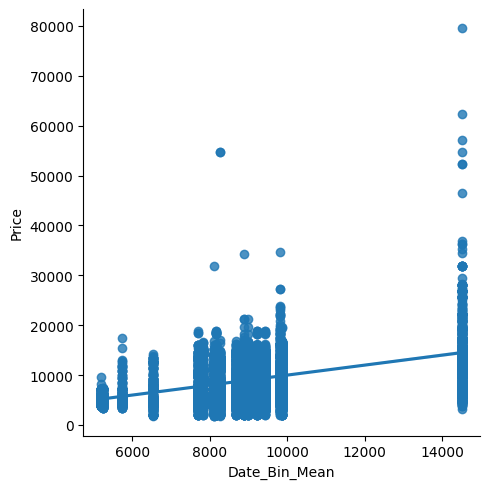

In [158]:
sns.lmplot(data=data,x='Date_Bin_Mean',y='Price')

In [159]:
#We have successfully turned the pattern into a linear relationship
data['Date_Bin_Mean'].corr(data['Price'])

0.4306009129509941

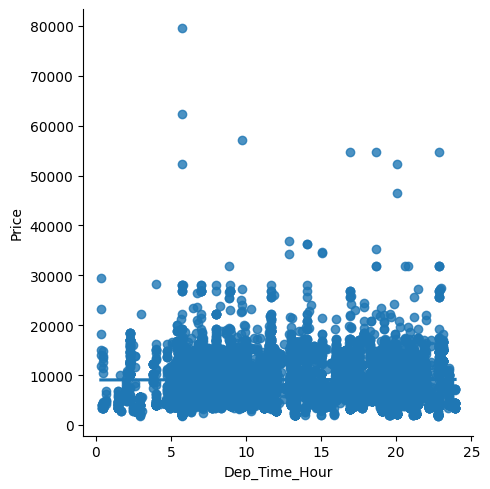

In [160]:
#Let's look at the departure and arrival times
plot=sns.lmplot(data=data,x='Dep_Time_Hour',y='Price')

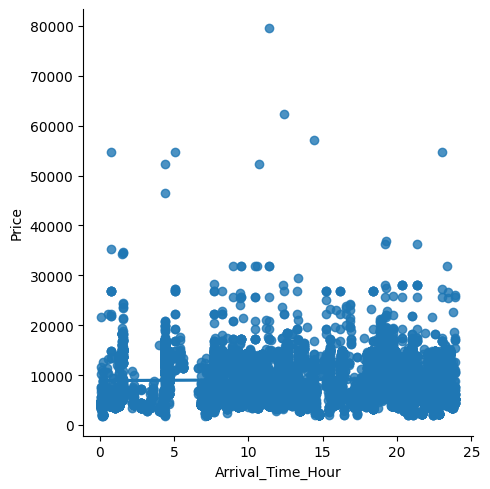

In [161]:
sns.lmplot(data=data,x='Arrival_Time_Hour',y='Price')

In [162]:
#No correlation but let's look at the mutual info
from sklearn.metrics import mutual_info_score
mutual_info_score(data['Dep_Time_Hour'],data['Price'])

c:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


3.6433886296254947

In [163]:
data['Arrival_Time_Hour'].corr(data['Price'])

0.020901114013397105

In [164]:
data['Arrival_Time_Hour'].corr(data['Price'])
mutual_info_score(data['Arrival_Time_Hour'],data['Price'])

c:\Python310\lib\site-packages\sklearn\metrics\cluster\_supervised.py:64: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)


3.6118451567504137

In [165]:
data['Arrival_Time_Hour'].corr(data['Price'])

0.020901114013397105

In [166]:
#Low correlation but high mutual information so definately useful

<Axes: xlabel='Date_of_Journey_Day_of_Week', ylabel='Price'>

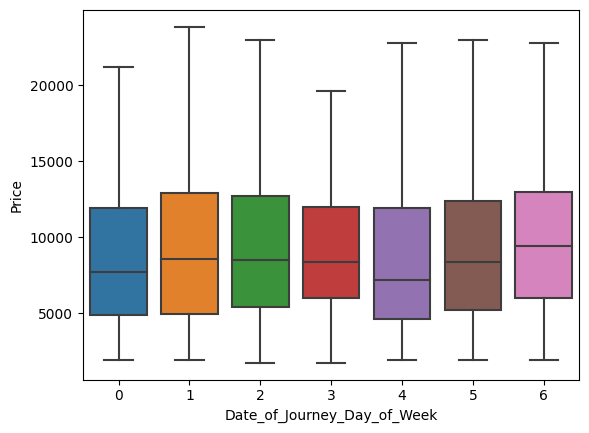

In [167]:
#Let's see the effect of the day of the week
sns.boxplot(data=data,x='Date_of_Journey_Day_of_Week',y='Price',showfliers=False)


In [168]:
data.groupby(data['Date_of_Journey_Day_of_Week'])['Price'].mean()

Date_of_Journey_Day_of_Week
0    8500.082207
1    9026.149597
2    9277.514190
3    8931.379367
4    9717.996700
5    8972.905389
6    9525.508820
Name: Price, dtype: float64

In [169]:
mutual_info_score(data['Date_of_Journey_Day_of_Week'],data['Price'])

0.7641307775625269

In [170]:
################
#Modeling
################

In [171]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops', 'Price',
       'Source-Destination', 'Route_Banglore-Delhi',
       'Route_Banglore-New Delhi', 'Route_Chennai-Kolkata',
       'Route_Delhi-Cochin', 'Route_Kolkata-Banglore',
       'Route_Mumbai-Hyderabad', 'Airline_Air Asia', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Dep_Time_Hour', 'Arrival_Time_Hour', 'Date_of_Journey_Month',
       'Date_of_Journey_Day_of_Week', 'Date_of_Week_Mean', 'Duration_Hour',
       'Stops_Count', 'Date_Bin', 'Date_Bin_Mean'],
      dtype='object')

In [172]:
train_data=data.select_dtypes([np.number]).copy()
train_data.drop(inplace=True,columns=['Date_of_Journey_Month']);
train_data.columns


Index(['Price', 'Route_Banglore-Delhi', 'Route_Banglore-New Delhi',
       'Route_Chennai-Kolkata', 'Route_Delhi-Cochin', 'Route_Kolkata-Banglore',
       'Route_Mumbai-Hyderabad', 'Airline_Air Asia', 'Airline_Air India',
       'Airline_GoAir', 'Airline_IndiGo', 'Airline_Jet Airways',
       'Airline_Jet Airways Business', 'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Dep_Time_Hour', 'Arrival_Time_Hour', 'Date_of_Journey_Day_of_Week',
       'Date_of_Week_Mean', 'Duration_Hour', 'Stops_Count', 'Date_Bin_Mean'],
      dtype='object')

In [173]:
x=train_data.drop(['Price'],axis=1)
y=train_data['Price']

In [174]:
from sklearn.feature_selection import mutual_info_regression
imp=pd.DataFrame(mutual_info_regression(x,y),index=x.columns)
imp.columns=['Importance']
imp.sort_values(by='Importance',ascending=False)

,Importance
Arrival_Time_Hour,2.131023
Dep_Time_Hour,2.002639
Duration_Hour,1.770530
Date_Bin_Mean,0.801586
Stops_Count,0.793605
Airline_Jet Airways,0.557500
Route_Delhi-Cochin,0.530708
Route_Kolkata-Banglore,0.454250
Airline_IndiGo,0.363658
Route_Banglore-Delhi,0.330757


In [175]:
#A lot of the airline have little to no impact on price... that doesn't seem right
data['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

In [176]:
#It seems I have made a mistake by one hot encoding the airline
#since the data isn't well distributed
#Let's re-encode
for airline in data['Airline'].unique():
  data.drop(inplace=True,columns='Airline_'+airline)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Airline                      10682 non-null  object        
 1   Date_of_Journey              10682 non-null  datetime64[ns]
 2   Source                       10682 non-null  object        
 3   Destination                  10682 non-null  object        
 4   Route                        10682 non-null  object        
 5   Dep_Time                     10682 non-null  datetime64[ns]
 6   Arrival_Time                 10682 non-null  datetime64[ns]
 7   Duration                     10682 non-null  object        
 8   Total_Stops                  10682 non-null  object        
 9   Price                        10682 non-null  int64         
 10  Source-Destination           10682 non-null  object        
 11  Route_Banglore-Delhi         10682 non-nu

In [177]:
#Let's encode
airlines=data.groupby(['Airline'])['Price'].mean().sort_values().index
al_dict={k:i for i,k in enumerate(airlines,0)}
data['Airline_Encoded']=data['Airline'].map(al_dict)
data[['Airline','Airline_Encoded','Price']].head(5)

,Airline,Airline_Encoded,Price
0,IndiGo,3,3897
1,Air India,7,7662
2,Jet Airways,10,13882
3,IndiGo,3,6218
4,IndiGo,3,13302


In [178]:
#That way, yes a lot of the information on the distribution of prices
#per airline has been lost, but at least we don't have the problem where
#regressor get a set of features containing only useless airlines

In [179]:
train_data=data.select_dtypes([np.number]).copy()
train_data.drop(inplace=True,columns=['Date_of_Journey_Month']);
train_data.columns

x=train_data.drop(['Price'],axis=1)
y=train_data['Price']

imp=pd.DataFrame(mutual_info_regression(x,y),index=x.columns)
imp.columns=['Importance']
imp.sort_values(by='Importance',ascending=False)


,Importance
Arrival_Time_Hour,2.129383
Dep_Time_Hour,2.001466
Duration_Hour,1.777460
Airline_Encoded,1.323355
Date_Bin_Mean,0.802522
Stops_Count,0.790458
Route_Delhi-Cochin,0.511884
Route_Kolkata-Banglore,0.448561
Route_Banglore-Delhi,0.333167
Date_of_Week_Mean,0.324381


In [180]:
#Lets train/test split the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [181]:
#Let's try a random forest regressor
from sklearn.ensemble import RandomForestRegressor
ml_model=RandomForestRegressor()
model=ml_model.fit(x_train,y_train)

In [182]:
def mape(y_true,y_pred):
  ytrue,ypred=np.array(y_true),np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [183]:
mape(y_test,y_pred=model.predict(x_test))

13.486645451355136

In [200]:
#Let's look at how a basic regression would perform
from sklearn.linear_model import LinearRegression
ml_model_2=LinearRegression()
model_2=ml_model_2.fit(x_train,y_train)

In [201]:
mape(y_test,y_pred=model_2.predict(x_test))

24.04742942016524

In [202]:
#Let's try to tune the random forest regressor
from sklearn.model_selection import RandomizedSearchCV
model_to_tune=RandomForestRegressor()

search_space={
  'n_estimators':[50,100,400,1000,1300],
  'max_depth':[5,8,11,14,17],
  'min_samples_split':[2,5,10,20,40,80]
}

In [203]:
tuned_model=RandomizedSearchCV(
  model_to_tune,param_distributions=search_space,
  cv=3,
  verbose=2,
  n_jobs=-1,
  random_state=42
)

In [204]:
tuned_model.fit(x_train,y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Python310\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


In [205]:
tuned_model.best_params_

{'n_estimators': 1000,
 'min_samples_split': 40,
 'max_features': 'auto',
 'max_depth': 11}

In [206]:
mape(y_test,y_pred=tuned_model.predict(x_test))

15.225384083129882

In [207]:
#We interestingly perform worst defaults parameters

#Default params:
#n_estimators=100
#min_samples_split=2
#max_depth=None(meaning # of features, 14)

#Either it is overfitting or the default parameters were really good
#If it is overfitting, then tuned hyperparameter should perform worst
#on the test-train split data but better withou the test-train split

#Let's see
mape(y_train,y_pred=tuned_model.predict(x_train))

14.308032296728229

In [210]:
#The tuned model performed better on the train data, but still not as much
#as with the default hyperparameters. Lets use GridSearch to confirm
from sklearn.model_selection import GridSearchCV
model_to_tune=RandomForestRegressor()
tuned_model=GridSearchCV(
  model_to_tune,
  param_grid=search_space,
  cv=3,
  verbose=2,
  n_jobs=-1,
)
tuned_model.fit(x_train,y_train);
mape(y_test,y_pred=tuned_model.predict(x_test))

Fitting 3 folds for each of 240 candidates, totalling 720 fits


14.779807032975048

In [211]:
tuned_model.best_params_

{'max_depth': 14,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 1000}